# Head to head

Trying to actively visualizing what's the purpose of each head


In [3]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
import torch.nn.functional as F

# Upload tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()


/home/riccorte/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-20 13:39:34.657663: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747741174.923937   12919 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747741174.991827   12919 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-20 13:39:36.020638: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operat

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [4]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [5]:
def plot_head_attention(text, layer, head):
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    tokens = [token.lstrip("Ġ") for token in tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])]

    
    attn = outputs.attentions[layer][0, head].detach().numpy()  # shape: (seq_len, seq_len)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(attn, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
    plt.title(f"Layer {layer}, Head {head}")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


In [9]:
def plot_all_heads(text, layer):
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    tokens = [token.lstrip("Ġ") for token in tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])]
    attns = outputs.attentions[layer][0]  # shape: (12, seq_len, seq_len)

    fig, axes = plt.subplots(3, 4, figsize=(16, 10))
    for i, ax in enumerate(axes.flat):
        sns.heatmap(attns[i].detach().numpy(), xticklabels=tokens, yticklabels=tokens,
                    cmap="viridis", ax=ax, cbar=False)
        ax.set_title(f"Head {i}")
        ax.tick_params(labelrotation=90)
    plt.tight_layout()
    plt.show()


In [10]:
# Example: extract the weights of layer 0, head 0
layer = model.transformer.h[0]
W_q = layer.attn.c_attn.weight[:768//3, :]  # First third of the weight matrix (for Q)
W_k = layer.attn.c_attn.weight[768//3:2*768//3, :]  # Second third (for K)
W_v = layer.attn.c_attn.weight[2*768//3:, :]  # Last third (for V)

print("W_q shape:", W_q.shape, W_q[0, :])
print("W_k shape:", W_k.shape)
print("W_v shape:", W_v.shape)


W_q shape: torch.Size([256, 2304]) tensor([-0.4738, -0.2614, -0.0978,  ...,  0.0513, -0.0584,  0.0250],
       grad_fn=<SliceBackward0>)
W_k shape: torch.Size([256, 2304])
W_v shape: torch.Size([256, 2304])


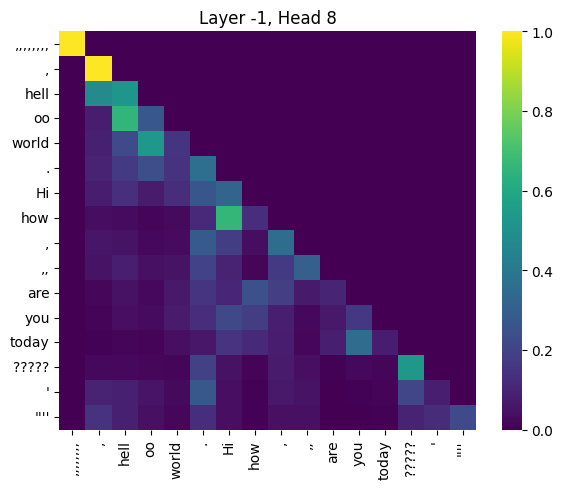

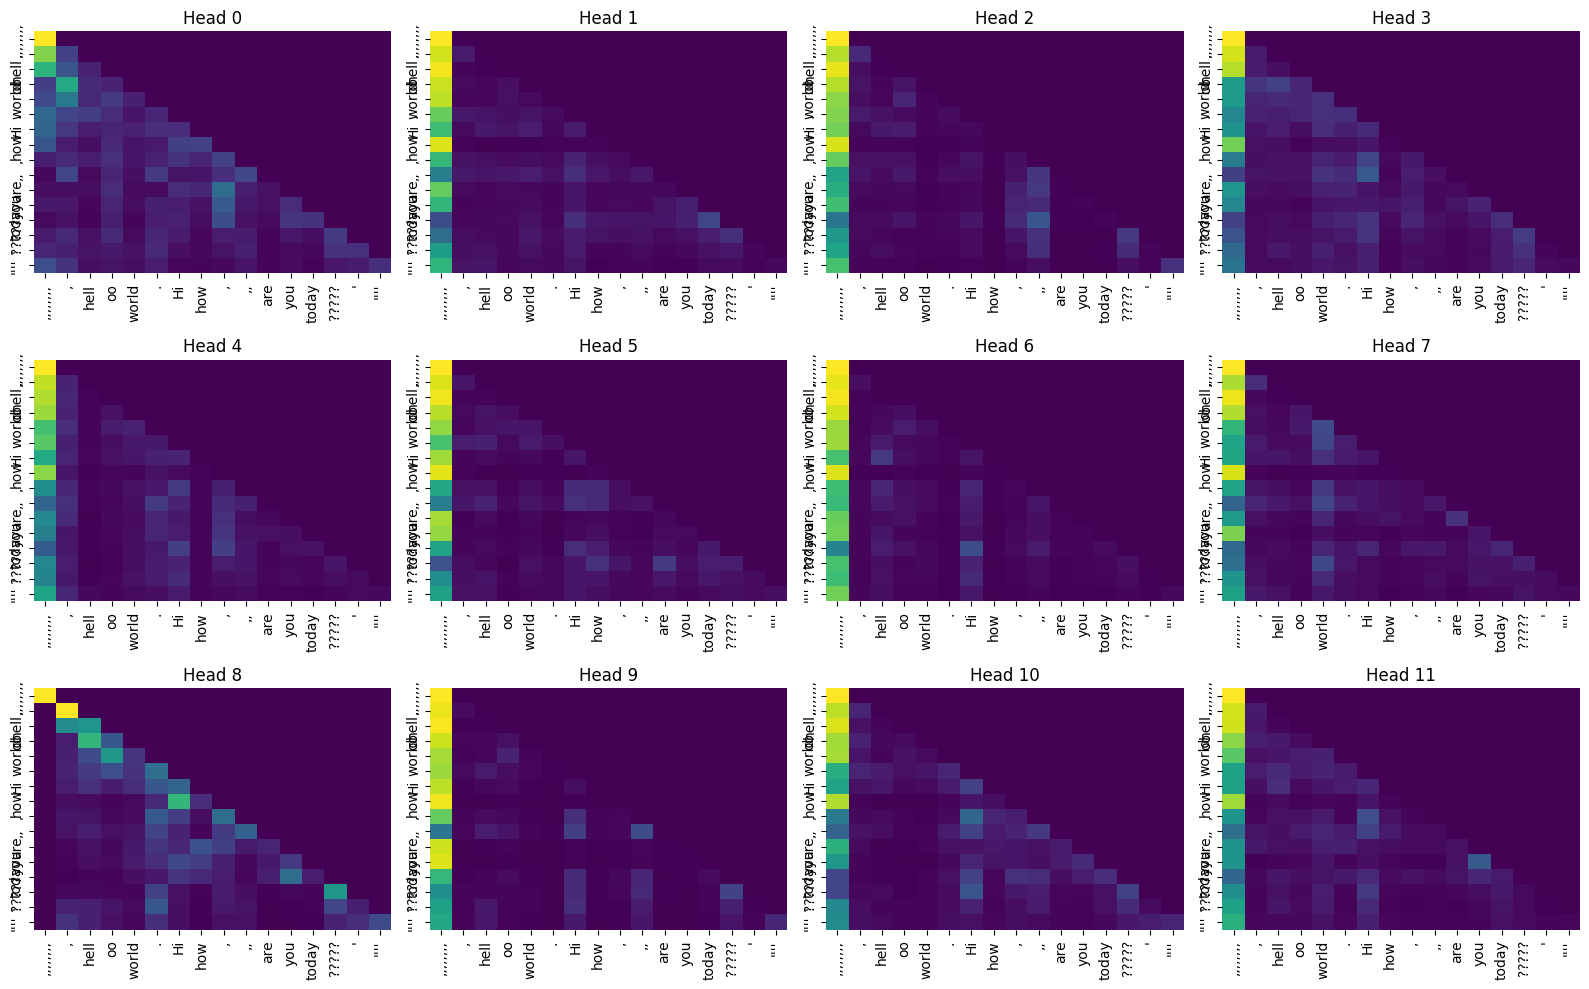

In [12]:
input_text = ",,,,,,,,, helloo world. Hi how ,,, are you today????? '''''"
plot_head_attention(input_text, layer=-1, head=8)
plot_all_heads(input_text, layer=-1)
